In [223]:
!python -V

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Optional, ClassVar
from datasets import Dataset as HFDataset
import json


import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Python 3.13.3
Using device: cpu


# 1. Загрузка данных + 2. Cоздание набора

In [224]:
@dataclass
class PokemonDataset:
    """Класс для загрузки и обработки изображений покемонов.
    
    Обеспечивает:
    - Загрузку изображений из директории
    - Преобразование в тензоры
    - Аугментацию данных
    - Разделение на обучающую и тестовую выборки
    
    Атрибуты:
        data_dir (str): Путь к директории с изображениями покемонов
        pokemons_names (List[str]): Список имен покемонов (поддиректории)
        data (List[torch.Tensor]): Список обработанных тензоров изображений
        labels (List[int]): Список меток классов
        transform (Optional[transforms.Compose]): Трансформации для изображений
        augment (bool): Флаг применения аугментации данных
    """
    
    data_dir: str
    pokemons_names: List[str] = field(default_factory=list)
    data: List[torch.Tensor] = field(default_factory=list)
    labels: List[int] = field(default_factory=list)
    transform: Optional[transforms.Compose] = None
    augment: bool = True
    
    # Стандартный размер изображений
    img_size: ClassVar[Tuple[int, int]] = (64, 64)
    
    # Доступные типы трансформаций
    transform_types: ClassVar[Dict[str, transforms.Compose]] = {
        'basic': transforms.Compose([
            transforms.Resize(img_size, antialias=True),
        ]),
        'augment': transforms.Compose([
            transforms.Resize(img_size, antialias=True),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

        ])
    }

    def __post_init__(self):
        """Инициализация после создания dataclass."""
        self.pokemons_names = sorted(os.listdir(self.data_dir))
        self.transform = self.transform_types['augment' if self.augment else 'basic']
        self.prepare_dataset()

    def load_image(self, filepath: str) -> Image.Image:
        """Загружает изображение из файла и конвертирует в RGB."""
        return Image.open(filepath).convert("RGB")

    def get_images_for_pokemon(self, pokemon_name: str) -> List[torch.Tensor]:
        """Загружает и преобразует все изображения для конкретного покемона."""
        pokemon_dir = os.path.join(self.data_dir, pokemon_name)
        return [
            self.transform(self.load_image(os.path.join(pokemon_dir, fname)))
            for fname in os.listdir(pokemon_dir)
            if fname.endswith(('.png', '.jpg', '.jpeg'))
        ]

    def prepare_dataset(self) -> None:
        """Подготавливает датасет, загружая и обрабатывая все изображения."""
        for idx, name in enumerate(self.pokemons_names):
            images = self.get_images_for_pokemon(name)
            self.data.extend(images)
            self.labels.extend([idx] * len(images))

    def train_test_split(self) -> Tuple[HFDataset, HFDataset, HFDataset]:
        """Разделяет датасет на обучающую и тестовую выборки с балансировкой классов.
        
        Возвращает:
            Кортеж содержащий:
                - train_dataset: Обучающая выборка с аугментированными изображениями
                - train_original: Оригинальные обучающие изображения без аугментации
                - test_dataset: Тестовая выборка
        """
        class_to_samples = {}
        for sample, label in zip(self.data, self.labels):
            class_to_samples.setdefault(label, []).append(sample)

        train_data, test_data, train_labels, test_labels = [], [], [], []
        
        for label, samples in class_to_samples.items():
            train_data.extend(samples[:-1])
            train_labels.extend([label] * (len(samples) - 1))
            if len(samples) > 1: 
                test_data.append(samples[-1])
                test_labels.append(label)

        # Создаем аугментированный датасет если включено
        if self.augment:
            train_data_aug, train_labels_aug = self.augment_data(train_data, train_labels)
            train_data += train_data_aug
            train_labels += train_labels_aug

        return (
            HFDataset.from_dict({"image": train_data, "label": train_labels}),
            HFDataset.from_dict({"image": test_data, "label": test_labels})
        )

    def augment_image(self, image: torch.Tensor, n_augmented: int = 30) -> List[torch.Tensor]:
        """Генерирует аугментированные версии изображения.
        
        Аргументы:
            image (torch.Tensor): Входной тензор изображения
            n_augmented (int): Количество аугментированных изображений для генерации
            
        Возвращает:
            List[torch.Tensor]: Список аугментированных тензоров изображений
        """
        augmenter = self.transform_types['augment']
        return [augmenter(image) for _ in range(n_augmented)]

    def augment_data(self, X: List[torch.Tensor], y: List[int]) -> Tuple[List[torch.Tensor], List[int]]:
        """Аугментирует данные, создавая модифицированные версии каждого изображения.
        
        Аргументы:
            X (List[torch.Tensor]): Список тензоров изображений
            y (List[int]): Соответствующие метки классов
            
        Возвращает:
            Кортеж из аугментированных изображений и соответствующих меток
        """
        augmented_X, augmented_y = [], []
        for img, label in zip(X, y):
            augmented_X.extend(self.augment_image(img))
            augmented_y.extend([label] * 30)  # 30 аугментированных версий на изображение
        return augmented_X, augmented_y

In [225]:
data_dir = "pokemon_data/images"
dataset = PokemonDataset(data_dir=data_dir)

print(f"Всего покемонов: {len(dataset.pokemons_names)}")

Всего покемонов: 898


# 3. Создание нейросетевой модели

In [226]:
class PokemonCNN(nn.Module):
    """Архитектура CNN для классификации покемонов."""    
    def __init__(self, num_classes):
        super(PokemonCNN, self).__init__()
        self.num_classes = num_classes
        self.in_channels = 3
        self.features = nn.Sequential(
            nn.Conv2d(self.in_channels, 6, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 16 * 16, 1024),
            nn.ReLU(),
            nn.Linear(1024, self.num_classes)
        )

    def forward(self, x):
        x = self.features(x.float())
        x = self.classifier(x)
        return x

model = PokemonCNN(num_classes=len(dataset.pokemons_names)).to(device)

# 4. Обучение модели

In [ ]:
@dataclass 
class PokemonTrainer:
    """Класс для обучения и оценки модели классификации покемонов."""
    
    model: nn.Module
    dataset: PokemonDataset
    device: torch.device
    epochs: int = 15
    batch_size: int = 8
    patience: int = 5
    
    def __post_init__(self):
        self.writer = SummaryWriter('runs/pokemon_experiment')
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.best_accuracy = 0.0
        
        self.train_ds, self.test_ds = self.dataset.train_test_split()
        print("Тренировочная подвыборка:\n", self.train_ds.num_rows, '\n')
        print("Тестовая подвыборка:\n", self.test_ds.num_rows, '\n')
        self.train_loader = DataLoader(self.train_ds.with_format("torch"), batch_size=self.batch_size, shuffle=True)
        self.test_loader = DataLoader(self.test_ds.with_format("torch"), batch_size=self.batch_size)
        
    def train_epoch(self, epoch):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch in self.train_loader:
            images = batch['image']
            labels = batch['label']
            
            if isinstance(images, list):
                images = torch.stack(images).to(self.device).float()
            if isinstance(labels, list):
                labels = torch.tensor(labels).to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = correct / total
        self.writer.add_scalar('Loss/train', epoch_loss, epoch)
        self.writer.add_scalar('Accuracy/train', epoch_acc, epoch)

        return epoch_loss, epoch_acc


    def validate(self, epoch):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in self.test_loader:
                images = batch['image']
                labels = batch['label']
                
                if isinstance(images, list):
                    images = torch.stack(images).to(self.device).float()
                if isinstance(labels, list):
                    labels = torch.tensor(labels).to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(self.test_loader)
        epoch_acc = correct / total
        self.writer.add_scalar('Loss/test', epoch_loss, epoch)
        self.writer.add_scalar('Accuracy/test', epoch_acc, epoch)

        if epoch_acc > self.best_accuracy:
            self.best_accuracy = epoch_acc
            torch.save(self.model.state_dict(), 'saved_models/best_pokemon_model.pth')

        return epoch_loss, epoch_acc

    
    def train(self):
        print("Начало обучения...")
        no_improve = 0
        
        for epoch in range(self.epochs):
            train_loss, train_acc = self.train_epoch(epoch)
            val_loss, val_acc = self.validate(epoch)
            
            print(f"Эпоха {epoch+1}/{self.epochs} | "
                  f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
            
            # Ранняя остановка
            if val_acc <= self.best_accuracy:
                no_improve += 1
                if no_improve >= self.patience:
                    print(f"Ранняя остановка на эпохе {epoch+1}")
                    break
            else:
                no_improve = 0
                
        self.writer.close()

trainer = PokemonTrainer(
    model=model,
    dataset=dataset,
    device=device,
    epochs=6
)
trainer.train()

Тренировочная подвыборка:
 49755 

Тестовая подвыборка:
 844 

Начало обучения...
Эпоха 1/6 | Train Loss: 5.5460, Acc: 0.0532 | Val Loss: 8.8782, Acc: 0.0415
Эпоха 2/6 | Train Loss: 1.7702, Acc: 0.5677 | Val Loss: 16.7020, Acc: 0.0900
Эпоха 3/6 | Train Loss: 0.2587, Acc: 0.9235 | Val Loss: 19.0544, Acc: 0.1386
Эпоха 4/6 | Train Loss: 0.1019, Acc: 0.9691 | Val Loss: 22.7367, Acc: 0.1149
Эпоха 5/6 | Train Loss: 0.0694, Acc: 0.9793 | Val Loss: 20.5656, Acc: 0.1457
Ранняя остановка на эпохе 5


# 5. Оценка результатов

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.33      1.00      0.50         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       1.00      1.00      1.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1
    

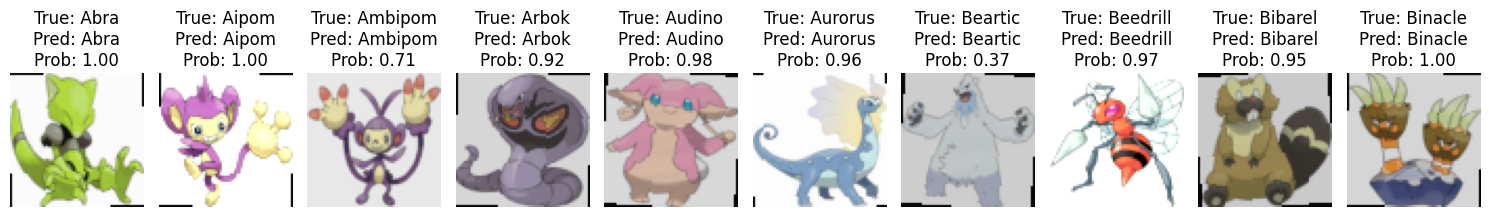


Примеры ошибочных предсказаний (721):


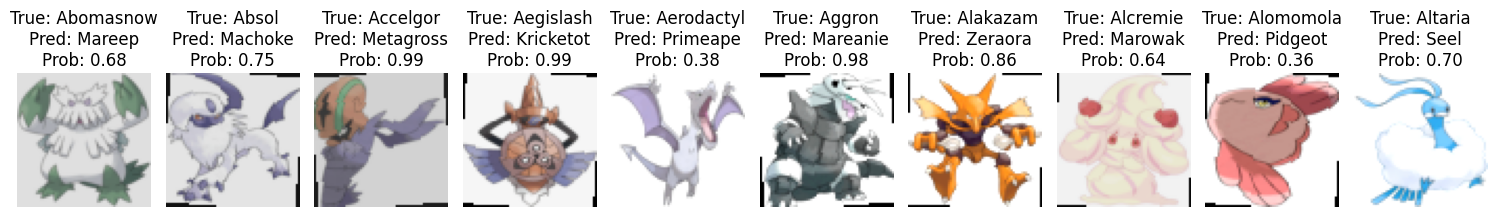

In [228]:
def evaluate_model(trainer):
    """Оценивает модель на тестовых и обучающих данных, визуализирует результаты."""
    trainer.model.load_state_dict(torch.load('saved_models/best_pokemon_model.pth'))
    trainer.model.eval()
    
    all_labels = []
    all_preds = []
    all_probs = []
    test_images = []
    
    with torch.no_grad():
        for batch in trainer.test_loader:
            images = batch['image']
            labels = batch['label']
            
            if isinstance(images, list):
                images = torch.stack(images).to(device).float()
            if isinstance(labels, list):
                labels = torch.tensor(labels).to(device)
            
            outputs = trainer.model(images)
            _, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            test_images.extend(images.cpu().numpy())
    
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, zero_division=0))
    
    # Матрица ошибок
    # plt.figure(figsize=(15, 15))
    # cm = confusion_matrix(all_labels, all_preds)
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
    #             xticklabels=dataset.pokemons_names, 
    #             yticklabels=dataset.pokemons_names)
    # plt.title('Confusion Matrix')
    # plt.xticks(rotation=90)
    # plt.yticks(rotation=0)
    # plt.tight_layout()
    # plt.show()
    
    plot_predictions(test_images, all_labels, all_preds, all_probs, dataset.pokemons_names)

def plot_predictions(images, labels, preds, probs, class_names, num_samples=10):
    """Визуализирует правильные и ошибочные предсказания."""
    correct_indices = [i for i, (l, p) in enumerate(zip(labels, preds)) if l == p]
    wrong_indices = [i for i, (l, p) in enumerate(zip(labels, preds)) if l != p]
    
    print(f"\nПримеры правильных предсказаний ({len(correct_indices)}):")
    plot_sample(images, labels, preds, probs, class_names, correct_indices, num_samples)
    
    print(f"\nПримеры ошибочных предсказаний ({len(wrong_indices)}):")
    plot_sample(images, labels, preds, probs, class_names, wrong_indices, num_samples)

def plot_sample(images, labels, preds, probs, class_names, indices, num_samples):
    """Отображает примеры изображений с предсказаниями."""
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices[:num_samples]):
        plt.subplot(1, num_samples, i+1)
        img = np.transpose(images[idx], (1, 2, 0))
        plt.imshow(img)
        plt.title(f"True: {class_names[labels[idx]]}\nPred: {class_names[preds[idx]]}\nProb: {probs[idx][preds[idx]]:.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

evaluate_model(trainer)

# 6. Демонстрация работы модели

In [251]:
def save_model(trainer, save_dir="saved_models"):
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, "pokemon_classifier.pth")
    torch.save({
        'model_state_dict': trainer.model.state_dict(),
        'class_names': trainer.dataset.pokemons_names,
        'img_size': trainer.dataset.img_size
    }, model_path)
    print(f"Модель сохранена в {model_path}")

def load_model(model_path, device):
    checkpoint = torch.load(model_path, map_location=device)
    model = PokemonCNN(num_classes=len(checkpoint['class_names'])).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model, checkpoint['class_names'], checkpoint['img_size']

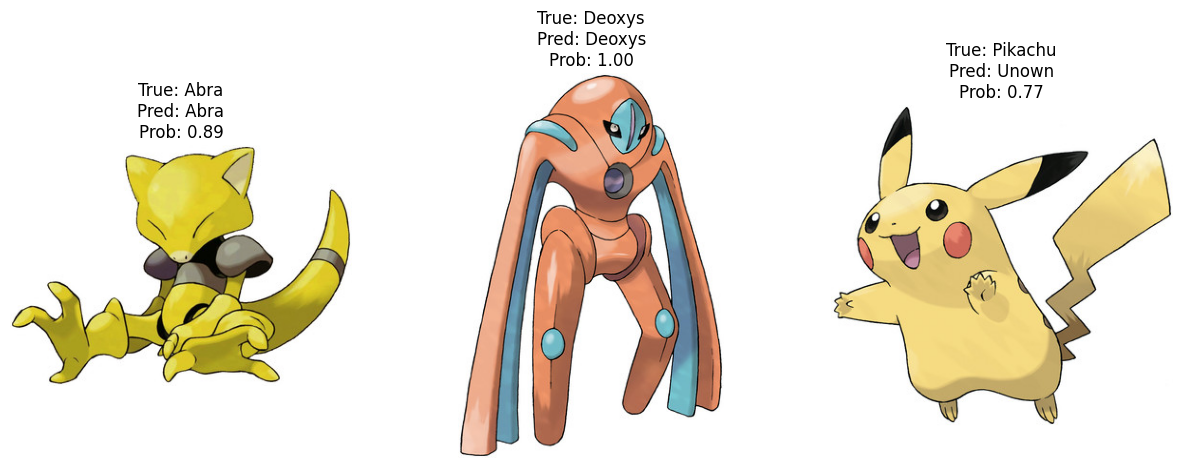

In [254]:
def predict_on_new_images(model, class_names, img_size, image_paths):
    transform = transforms.Compose([
        transforms.Resize(img_size, antialias=True),
        transforms.ToTensor(),
    ])
    
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(image_paths):
        img = Image.open(img_path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(img_tensor)
            prob = torch.nn.functional.softmax(output, dim=1)
            pred = torch.argmax(prob).item()
        
        plt.subplot(1, len(image_paths), i+1)
        plt.imshow(img)
        plt.title(f"True: {os.path.basename(os.path.dirname(img_path))}\nPred: {class_names[pred]}\nProb: {prob[0][pred]:.2f}")
        plt.axis('off')
    plt.show()
    
model_path = "saved_models/pokemon_classifier.pth"
loaded_model, class_names, img_size = load_model(model_path, device)

test_images = ["pokemon_data/images/Abra/0.jpg",  "pokemon_data/images/Deoxys/2.jpg", "pokemon_data/images/Pikachu/0.jpg"]
predict_on_new_images(loaded_model, class_names, img_size, test_images)

# 7. Выводы

1. Что не работает:
   - Обучение без аугментации (много классов на выходе, но слишком мало данных).  
   - Серая шкала вместо RGB (цвет критически важен).  
   - Большие батчи (ухудшают сходимость).  

2. Решенные проблемы:
   - Нехватка данных → аугментация.  
   - Медленная сходимость → BatchNorm + ReLU.  
   - Низкая точность → оптимизация архитектуры 

3. Улучшения:
   - Больше данных (главная проблема).  
   - Регуляризация: Dropout, L2, MixUp.  
   - Перенос обучения (Transfer Learning).  
   - Оптимизация LR (схемы снижения, циклические LR).  

Для датасета с 898 классами и малым количеством изображений на класс (1–5) можно использовать Few-Shot Learning.

Итог: Модель ограничена малым датасетом. Лучший способ улучшить результат — собрать больше данных и применить Transfer Learning.

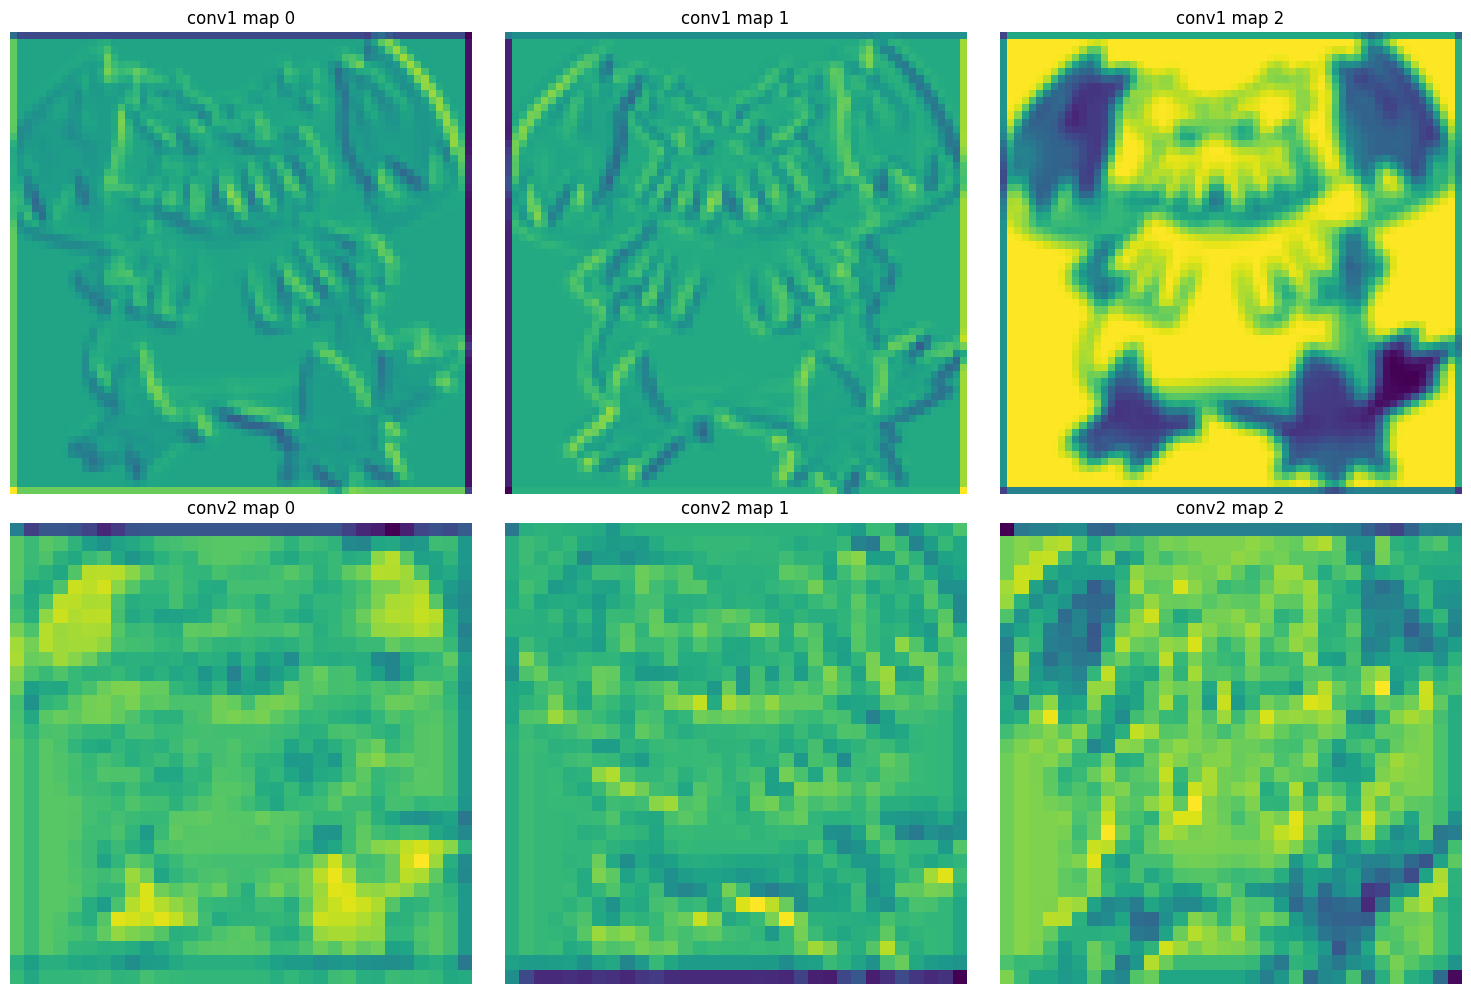

In [ ]:
def visualize_features(model, images, class_names):
    """Визуализирует активации слоев."""
    activations = {}
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook
    
    model.features[0].register_forward_hook(get_activation('conv1'))
    model.features[3].register_forward_hook(get_activation('conv2'))
    # model.features[6].register_forward_hook(get_activation('conv3'))
    
    with torch.no_grad():
        _ = model(images)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    for i, (name, act) in enumerate(activations.items()):
        for j in range(3):
            axes[i,j].imshow(act[0, j].cpu().numpy(), cmap='viridis')
            axes[i,j].set_title(f"{name} map {j}")
            axes[i,j].axis('off')
    plt.tight_layout()
    plt.show()

sample_images = next(iter(trainer.test_loader))['image'][:1].to(device)
visualize_features(model, sample_images, dataset.pokemons_names)

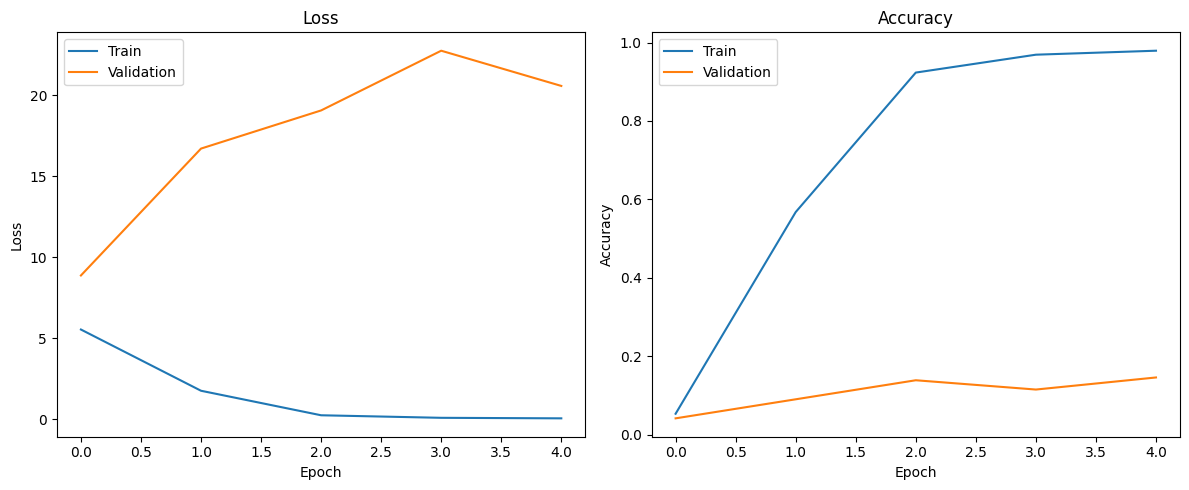

In [ ]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def plot_training_metrics(log_dir='runs/pokemon_experiment'):
    """Строит графики метрик обучения из TensorBoard."""
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    for e in EventAccumulator(log_dir).Reload().scalars.Items('Loss/train'):
        train_loss.append((e.step, e.value))
    for e in EventAccumulator(log_dir).Reload().scalars.Items('Loss/test'):
        val_loss.append((e.step, e.value))
    for e in EventAccumulator(log_dir).Reload().scalars.Items('Accuracy/train'):
        train_acc.append((e.step, e.value))
    for e in EventAccumulator(log_dir).Reload().scalars.Items('Accuracy/test'):
        val_acc.append((e.step, e.value))
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(*zip(*train_loss), label='Train')
    plt.plot(*zip(*val_loss), label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(*zip(*train_acc), label='Train')
    plt.plot(*zip(*val_acc), label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_metrics()